In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [52]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
from nltk.corpus import stopwords
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
import chardet

%matplotlib inline


In [5]:
file = '/content/drive/My Drive/spam.csv'

In [ ]:
with open(file, 'rb') as rawdata:
    result = chardet.detect(rawdata.read(100000))
result

In [6]:
data=pd.read_csv(file, encoding='Windows-1252')
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [7]:
data.dropna(how="any", inplace=True, axis=1)
data.columns = ['label', 'message']
data.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [8]:
data.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham      4825   4516                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

In [9]:
data['label_num'] = data.label.map({'ham':0, 'spam':1})
data.head()

,label,message,label_num
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


In [10]:
data['message_len'] = data.message.apply(len)
data.head()

,label,message,label_num,message_len
0,ham,"Go until jurong point, crazy.. Available only ...",0,111
1,ham,Ok lar... Joking wif u oni...,0,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,155
3,ham,U dun say so early hor... U c already then say...,0,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,61


Text(0.5, 0, 'Message Length')

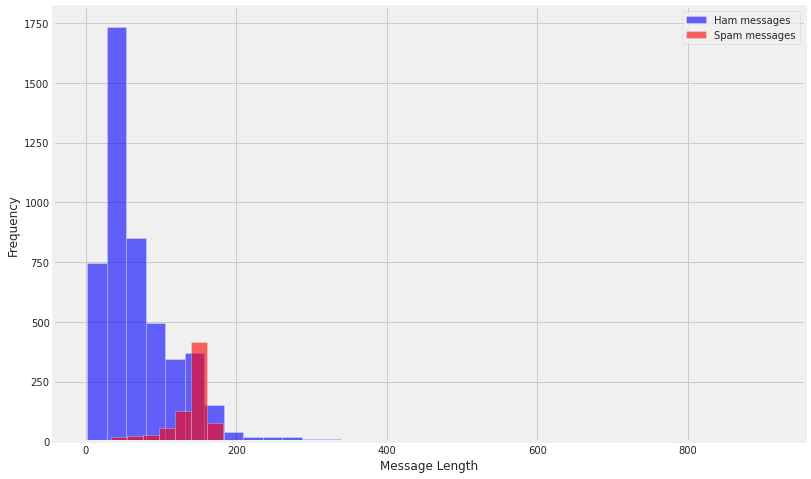

In [53]:
plt.figure(figsize=(12, 8))

data[data.label=='ham'].message_len.plot(bins=35, kind='hist', color='blue', 
                                       label='Ham messages', alpha=0.6)
data[data.label=='spam'].message_len.plot(kind='hist', color='red', 
                                       label='Spam messages', alpha=0.6)
plt.legend()
plt.xlabel("Message Length")

In [12]:

def text_process(mess):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    STOPWORDS = stopwords.words('english') + ['u', 'ü', 'ur', '4', '2', 'im', 'dont', 'doin', 'ure']
    # Check characters to see if they are in punctuation
    nopunc = [char for char in mess if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Now just remove any stopwords
    return ' '.join([word for word in nopunc.split() if word.lower() not in STOPWORDS])

In [16]:
import nltk
nltk.download('stopwords')
data['clean_msg'] = data.message.apply(text_process)
data.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,label,message,label_num,message_len,clean_msg
0,ham,"Go until jurong point, crazy.. Available only ...",0,111,Go jurong point crazy Available bugis n great ...
1,ham,Ok lar... Joking wif u oni...,0,29,Ok lar Joking wif oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,155,Free entry wkly comp win FA Cup final tkts 21s...
3,ham,U dun say so early hor... U c already then say...,0,49,dun say early hor c already say
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,61,Nah think goes usf lives around though


In [17]:
words = data[data.label=='ham'].clean_msg.apply(lambda x: [word.lower() for word in x.split()])
ham_words = Counter()

for msg in words:
    ham_words.update(msg)
    
print(ham_words.most_common(50))

[('get', 303), ('ltgt', 276), ('ok', 272), ('go', 247), ('ill', 236), ('know', 232), ('got', 231), ('like', 229), ('call', 229), ('come', 224), ('good', 222), ('time', 189), ('day', 187), ('love', 185), ('going', 167), ('want', 163), ('one', 162), ('home', 160), ('lor', 160), ('need', 156), ('sorry', 153), ('still', 146), ('see', 137), ('n', 134), ('later', 134), ('da', 131), ('r', 131), ('back', 129), ('think', 128), ('well', 126), ('today', 125), ('send', 123), ('tell', 121), ('cant', 118), ('ì', 117), ('hi', 117), ('take', 112), ('much', 112), ('oh', 111), ('night', 107), ('hey', 106), ('happy', 105), ('great', 100), ('way', 100), ('hope', 99), ('pls', 98), ('work', 96), ('wat', 95), ('thats', 94), ('dear', 94)]


In [18]:
words = data[data.label=='spam'].clean_msg.apply(lambda x: [word.lower() for word in x.split()])
spam_words = Counter()

for msg in words:
    spam_words.update(msg)
    
print(spam_words.most_common(50))

[('call', 347), ('free', 216), ('txt', 150), ('mobile', 123), ('text', 120), ('claim', 113), ('stop', 113), ('reply', 101), ('prize', 92), ('get', 83), ('new', 69), ('send', 67), ('nokia', 65), ('urgent', 63), ('cash', 62), ('win', 60), ('contact', 56), ('service', 55), ('please', 52), ('guaranteed', 50), ('customer', 49), ('16', 49), ('week', 49), ('tone', 48), ('per', 46), ('phone', 45), ('18', 43), ('chat', 42), ('awarded', 38), ('draw', 38), ('latest', 36), ('å£1000', 35), ('line', 35), ('150ppm', 34), ('mins', 34), ('receive', 33), ('camera', 33), ('1', 33), ('every', 33), ('message', 32), ('holiday', 32), ('landline', 32), ('shows', 31), ('å£2000', 31), ('go', 31), ('box', 30), ('number', 30), ('apply', 29), ('code', 29), ('live', 29)]


In [19]:
X = data.clean_msg
y = data.label_num
print(X.shape)
print(y.shape)

(5572,)
(5572,)


In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(4179,)
(1393,)
(4179,)
(1393,)


In [21]:
vect = CountVectorizer()
vect.fit(X_train)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [25]:
X_train[1]

'Ok lar Joking wif oni'

In [26]:
X_train_dtm = vect.transform(X_train)

In [27]:
X_train_dtm = vect.fit_transform(X_train)

In [28]:
X_test_dtm = vect.transform(X_test)
X_test_dtm

<1393x7996 sparse matrix of type '<class 'numpy.int64'>'
	with 9971 stored elements in Compressed Sparse Row format>

In [29]:
tfidf_transformer = TfidfTransformer()
tfidf_transformer.fit(X_train_dtm)
tfidf_transformer.transform(X_train_dtm)

<4179x7996 sparse matrix of type '<class 'numpy.float64'>'
	with 34796 stored elements in Compressed Sparse Row format>

Наивный Байесовский классификатор


In [80]:
nb = MultinomialNB()

In [81]:
%time nb.fit(X_train_dtm, y_train)

CPU times: user 5.15 ms, sys: 1.04 ms, total: 6.2 ms
Wall time: 9.67 ms


MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [82]:
y_pred_class = nb.predict(X_test_dtm)

In [85]:
from sklearn import metrics
print("Accuracy:", metrics.accuracy_score(y_test, y_pred_class))
print("Recall:", metrics.recall_score(y_test, y_pred_class, average = 'macro'))
print("Precision:", metrics.precision_score(y_test, y_pred_class, average = 'macro'))
print("Confusion matrix:\n", metrics.confusion_matrix(y_test, y_pred_class))
print("F1:", metrics.f1_score(y_test, y_pred_class))
print(metrics.classification_report(y_test, y_pred_class))
print("ROC score:",metrics.roc_auc_score(y_test, y_pred_class))

Accuracy: 0.9827709978463748
Recall: 0.9522579463222497
Precision: 0.9701921794945051
Confusion matrix:
 [[1205    8]
 [  16  164]]
F1: 0.9318181818181819
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1213
           1       0.95      0.91      0.93       180

    accuracy                           0.98      1393
   macro avg       0.97      0.95      0.96      1393
weighted avg       0.98      0.98      0.98      1393

ROC score: 0.9522579463222496


In [67]:
y_pred_prob = nb.predict_proba(X_test_dtm)[:, 1]

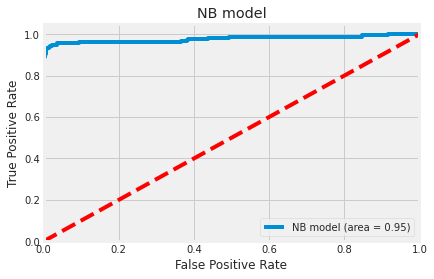

In [69]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, y_pred_class)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.figure()
plt.plot(fpr, tpr, label='NB model (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('NB model')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

Логистическая регрессия

In [95]:
logreg = LogisticRegression(solver='liblinear')
%time logreg.fit(X_train_dtm, y_train)
y_pred_class = logreg.predict(X_test_dtm)
y_pred_prob = logreg.predict_proba(X_test_dtm)[:, 1]

CPU times: user 18.8 ms, sys: 0 ns, total: 18.8 ms
Wall time: 21.1 ms


In [96]:
print("Accuracy:", metrics.accuracy_score(y_test, y_pred_class))
print("Recall:", metrics.recall_score(y_test, y_pred_class))
print("Precision:", metrics.precision_score(y_test, y_pred_class))
print("ROC AUC:", metrics.roc_auc_score(y_test, y_pred_prob, multi_class='multinomial'))
print("F1:", metrics.f1_score(y_test, y_pred_class))
print("Confusion matrix:\n", metrics.confusion_matrix(y_test, y_pred_class))
print(metrics.classification_report(y_test, y_pred_class))

Accuracy: 0.9842067480258435
Recall: 0.8777777777777778
Precision: 1.0
ROC AUC: 0.9835714940001832
F1: 0.9349112426035503
Confusion matrix:
 [[1213    0]
 [  22  158]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1213
           1       1.00      0.88      0.93       180

    accuracy                           0.98      1393
   macro avg       0.99      0.94      0.96      1393
weighted avg       0.98      0.98      0.98      1393



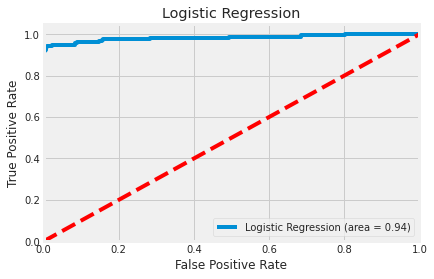

In [97]:
logit_roc_auc = roc_auc_score(y_test, y_pred_class)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

KNN классификатор


In [98]:
from sklearn.neighbors import KNeighborsClassifier

In [101]:
knn = KNeighborsClassifier(n_neighbors = 20)
%time knn.fit(X_train_dtm, y_train)
y_pred_class = knn.predict(X_test_dtm)
y_pred_prob = knn.predict_proba(X_test_dtm)[:, 1]
print("Accuracy:", metrics.accuracy_score(y_test, y_pred_class))
print("Recall:", metrics.recall_score(y_test, y_pred_class))
print("Precision:", metrics.precision_score(y_test, y_pred_class))
print("ROC AUC:", metrics.roc_auc_score(y_test, y_pred_prob, multi_class='multinomial'))
print("F1:", metrics.f1_score(y_test, y_pred_class))
print("Confusion matrix:\n", metrics.confusion_matrix(y_test, y_pred_class))
print(metrics.classification_report(y_test, y_pred_class))



CPU times: user 1.57 ms, sys: 0 ns, total: 1.57 ms
Wall time: 2.22 ms
Accuracy: 0.873653984206748
Recall: 0.022222222222222223
Precision: 1.0
ROC AUC: 0.8493816982687551
F1: 0.04347826086956522
Confusion matrix:
 [[1213    0]
 [ 176    4]]
              precision    recall  f1-score   support

           0       0.87      1.00      0.93      1213
           1       1.00      0.02      0.04       180

    accuracy                           0.87      1393
   macro avg       0.94      0.51      0.49      1393
weighted avg       0.89      0.87      0.82      1393



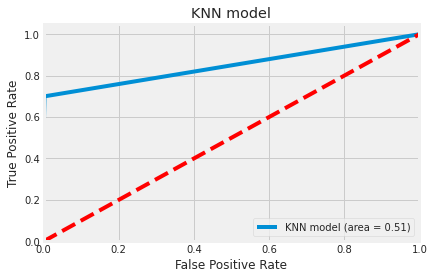

In [79]:
logit_roc_auc = roc_auc_score(y_test, y_pred_class)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.figure()
plt.plot(fpr, tpr, label='KNN model (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('KNN model')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()